# Unzip dataset

In [0]:
cd /content/drive/My\ Drive/Kaggle/

/content/drive/My Drive/Kaggle


In [0]:
%%capture
!mkdir /tmp/inputs
!unzip -q ./test_512.zip -d /tmp/inputs/test
!pip install pydicom
!pip install efficientnet

# Loading Libraries

In [0]:
import numpy as np
import pandas as pd
import gc
import keras
import datetime
import pydicom
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


# Setting main hyperparameters

In [0]:
batch_size = 16
img_size = 512
print('Image size of: {}'.format(img_size))

Image size of: 512


# Data Preprocessing

In [0]:
test_dir = '/tmp/inputs/test/'

In [0]:
print('No. of test images:', len(glob.glob('/tmp/inputs/test/*.png')))

No. of test images: 3205


## Defining Losses

### Dice Loss

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# U++ Efficientnet Model

In [0]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

## Defining U++ Efficientnet Model

In [0]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation='sigmoid')(uconv0)
    
    model = Model(input, output_layer)
    model.name = 'u++-efficientnet'

    return model

In [0]:
K.clear_session()
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

W0901 12:34:29.967262 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0901 12:34:30.008565 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0901 12:34:30.016463 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 12:34:30.018237 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W09

71720960/71719528 [==============================] - 2s 0us/step


W0901 12:34:54.392246 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0901 12:34:54.402736 139773979068288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Model compilation

In [0]:
model.compile(loss=bce_dice_loss, optimizer='adam')

W0901 12:34:57.930191 139773979068288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0901 12:34:57.968477 139773979068288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.load_weights('./My_Model/Best Model 1/best_model_weights.model')

# Test Set Prediction with TTA

In [0]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [0]:
threshold_best = 0.5 #0.5033333333333333

In [0]:
test_fn = sorted(glob.glob('/tmp/inputs/test/*'))

## Part 1

In [0]:
test_fn = test_fn[:1603]

In [0]:
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=8)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=8)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped
# del x_test; gc.collect()

(1603, 512, 512, 3)


### Plot some test predictions

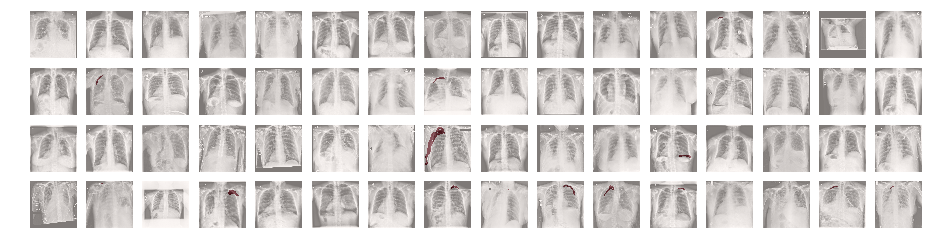

In [0]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

### Submition file

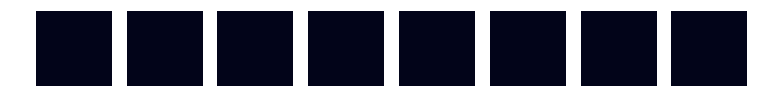

In [0]:
from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    mask = cv2.resize(p,(1024,1024))
    mask = mask > threshold_best
    #   zero out the smaller regions.
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    for c in range(1, num_component):
        zone = (component == c)
        if zone.sum() > 2000: #min_size
            predictions[zone] = 1
    predictions = (predictions.T*255).astype(np.uint8)  
    rles.append(mask2rle(predictions, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(predictions)
        plt.axis('off')

In [0]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df_part1 = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df_part1.loc[sub_df_part1.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df_part1.head()

,ImageId,EncodedPixels
0,ID_0011fe81e,-1
1,ID_003206608,-1
2,ID_004d6fbb6,-1
3,ID_004d72c54,-1
4,ID_00528aa0e,-1


In [0]:
sub_df_part1.to_csv('./submission_part1.csv', index=False)

## Part 2

In [0]:
test_fn = test_fn[1603:]

In [0]:
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=8)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=8)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped

(1602, 512, 512, 3)


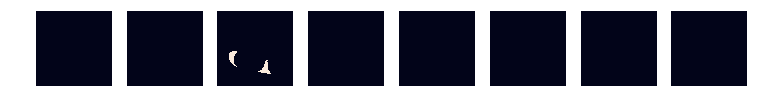

In [0]:
from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    mask = cv2.resize(p,(1024,1024))
    mask = mask > threshold_best
    #   zero out the smaller regions.
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    for c in range(1, num_component):
        zone = (component == c)
        if zone.sum() > 2000: #min_size
            predictions[zone] = 1
    predictions = (predictions.T*255).astype(np.uint8)  
    rles.append(mask2rle(predictions, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(predictions)
        plt.axis('off')

In [0]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df_part2 = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df_part2.loc[sub_df_part2.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df_part2.head()

,ImageId,EncodedPixels
0,ID_7da7f0b1c,-1
1,ID_7dd6c9d4c,-1
2,ID_7e534f1f1,568544 21 999 26 993 56 966 58 959 69 951 73 9...
3,ID_7e773894d,-1
4,ID_7e87208de,-1


# Submisson

In [0]:
sub_df_part1 = pd.read_csv('./submission_part1.csv')

In [0]:
sub_df = pd.concat([sub_df_part1, sub_df_part2])
sub_df.head()

,ImageId,EncodedPixels
0,ID_0011fe81e,-1
1,ID_003206608,-1
2,ID_004d6fbb6,-1
3,ID_004d72c54,-1
4,ID_00528aa0e,-1


In [0]:
sub_df.to_csv('./submission_model_1.csv', index=False)

In [0]:
!rm submission_part1.csv